In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random

%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.figsize'] = (20.0, 10.0) # set default size of plots

In [2]:
def fullseed(seed: int):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic=True


In [3]:
seed = 1344
fullseed(seed)

# Transfer learning

**ConvNet as fixed feature extractor.** Take a ConvNet pretrained on ImageNet, remove the last fully-connected layer (this layer’s outputs are the 1000 class scores for a different task like ImageNet), then treat the rest of the ConvNet as a fixed feature extractor for the new dataset. In an AlexNet, this would compute a 4096-D vector for every image that contains the activations of the hidden layer immediately before the classifier. We call these features CNN codes. It is important for performance that these codes are ReLUd (i.e. thresholded at zero) if they were also thresholded during the training of the ConvNet on ImageNet (as is usually the case). Once you extract the 4096-D codes for all images, train a linear classifier (e.g. Linear SVM or Softmax classifier) for the new dataset.


**Fine-tuning the ConvNet.** The second strategy is to not only replace and retrain the classifier on top of the ConvNet on the new dataset, but to also fine-tune the weights of the pretrained network by continuing the backpropagation. It is possible to fine-tune all the layers of the ConvNet, or it’s possible to keep some of the earlier layers fixed (due to overfitting concerns) and only fine-tune some higher-level portion of the network. This is motivated by the observation that the earlier features of a ConvNet contain more generic features (e.g. edge detectors or color blob detectors) that should be useful to many tasks, but later layers of the ConvNet becomes progressively more specific to the details of the classes contained in the original dataset. In case of ImageNet for example, which contains many dog breeds, a significant portion of the representational power of the ConvNet may be devoted to features that are specific to differentiating between dog breeds.

**New dataset is small and similar to original dataset**. Since the data is small, it is not a good idea to fine-tune the ConvNet due to overfitting concerns. Since the data is similar to the original data, we expect higher-level features in the ConvNet to be relevant to this dataset as well. Hence, the best idea might be to train a linear classifier on the CNN codes.


**New dataset is large and similar to the original dataset**. Since we have more data, we can have more confidence that we won’t overfit if we were to try to fine-tune through the full network.


**New dataset is small but very different from the original dataset**. Since the data is small, it is likely best to only train a linear classifier. Since the dataset is very different, it might not be best to train the classifier form the top of the network, which contains more dataset-specific features. Instead, it might work better to train the SVM classifier from activations somewhere earlier in the network.


**New dataset is large and very different from the original dataset**. Since the dataset is very large, we may expect that we can afford to train a ConvNet from scratch. However, in practice it is very often still beneficial to initialize with weights from a pretrained model. In this case, we would have enough data and confidence to fine-tune through the entire network.

Source: https://cs231n.github.io/transfer-learning/

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**cats** and **dogs**. We have  200 training images each for cats and dogs.
There are 70 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of https://huggingface.co/datasets/cats_vs_dogs.

In [19]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'cats_vs_dogs'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=x=="train", num_workers=4, worker_init_fn=fullseed(seed))
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [20]:
dataset_sizes

{'train': 400, 'val': 140}

Visualize a few images

Let's visualize a few training images so as to understand the data
augmentations.



Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.7/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.7/shutil.py", line 498, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.7/shutil.py", line 496, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-h0z6u8sh'


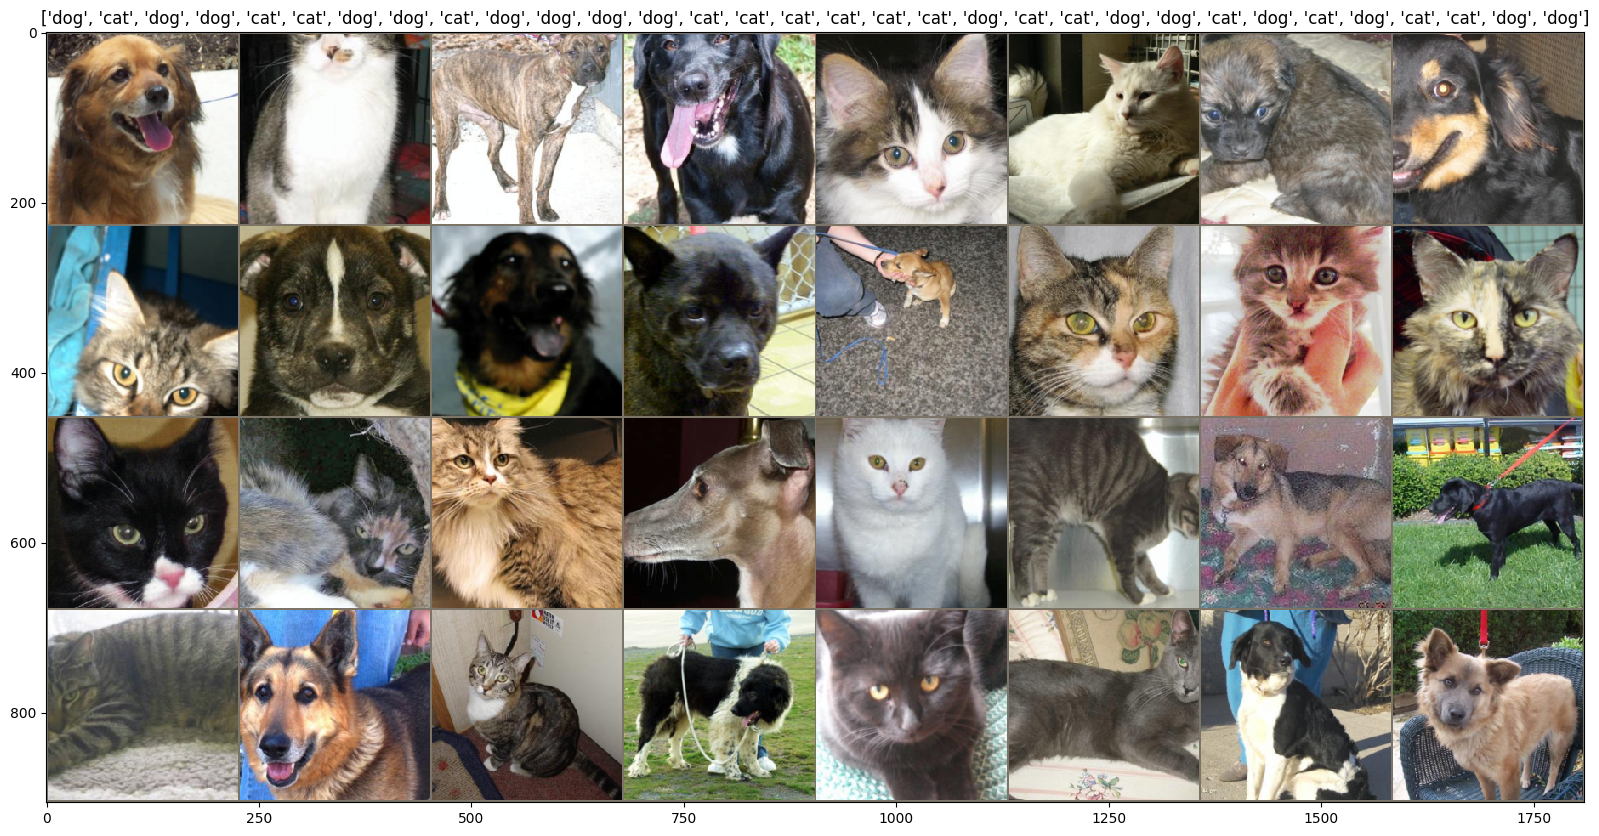

In [21]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Training the model

In [22]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25, step_every_batch=False):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    lrs = []
    losses = {"train": [], "val": []}
    metrics = {"train": [], "val": []}
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            
            if phase == 'train':
                lrs.append(optimizer.param_groups[0]['lr'])
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        if scheduler and step_every_batch:
                            scheduler.step()
                        
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                if scheduler and not step_every_batch:
                    scheduler.step()
                

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            losses[phase].append(epoch_loss)
            metrics[phase].append(epoch_acc.detach().cpu().numpy())
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    fig, axs = plt.subplots(1, 3)
    
    
    axs[0].plot(range(num_epochs), lrs)
    axs[0].legend(["lr"])
    
    
    for phase in ['train', 'val']:
        axs[1].plot(range(num_epochs), np.clip(losses[phase],a_min=0, a_max=1))
    axs[1].legend(["train loss", "val loss"])
    
    for phase in ['train', 'val']:
        axs[2].plot(range(num_epochs), metrics[phase])
    axs[2].legend(["train acc", "val acc"])
    return model

In [23]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




Epoch 0/9
----------
train Loss: 0.5754 Acc: 0.6825
val Loss: 0.2472 Acc: 0.9643

Epoch 1/9
----------
train Loss: 0.1748 Acc: 0.9625
val Loss: 0.1193 Acc: 0.9714

Epoch 2/9
----------
train Loss: 0.0922 Acc: 0.9800
val Loss: 0.0809 Acc: 0.9786

Epoch 3/9
----------
train Loss: 0.0682 Acc: 0.9900
val Loss: 0.0774 Acc: 0.9714

Epoch 4/9
----------
train Loss: 0.0355 Acc: 1.0000
val Loss: 0.0706 Acc: 0.9714

Epoch 5/9
----------
train Loss: 0.0282 Acc: 1.0000
val Loss: 0.0749 Acc: 0.9643

Epoch 6/9
----------
train Loss: 0.0306 Acc: 0.9975
val Loss: 0.0749 Acc: 0.9643

Epoch 7/9
----------
train Loss: 0.0244 Acc: 1.0000
val Loss: 0.0689 Acc: 0.9643

Epoch 8/9
----------
train Loss: 0.0319 Acc: 1.0000
val Loss: 0.0733 Acc: 0.9643

Epoch 9/9
----------
train Loss: 0.0240 Acc: 1.0000
val Loss: 0.0655 Acc: 0.9714

Training complete in 0m 8s
Best val Acc: 0.978571


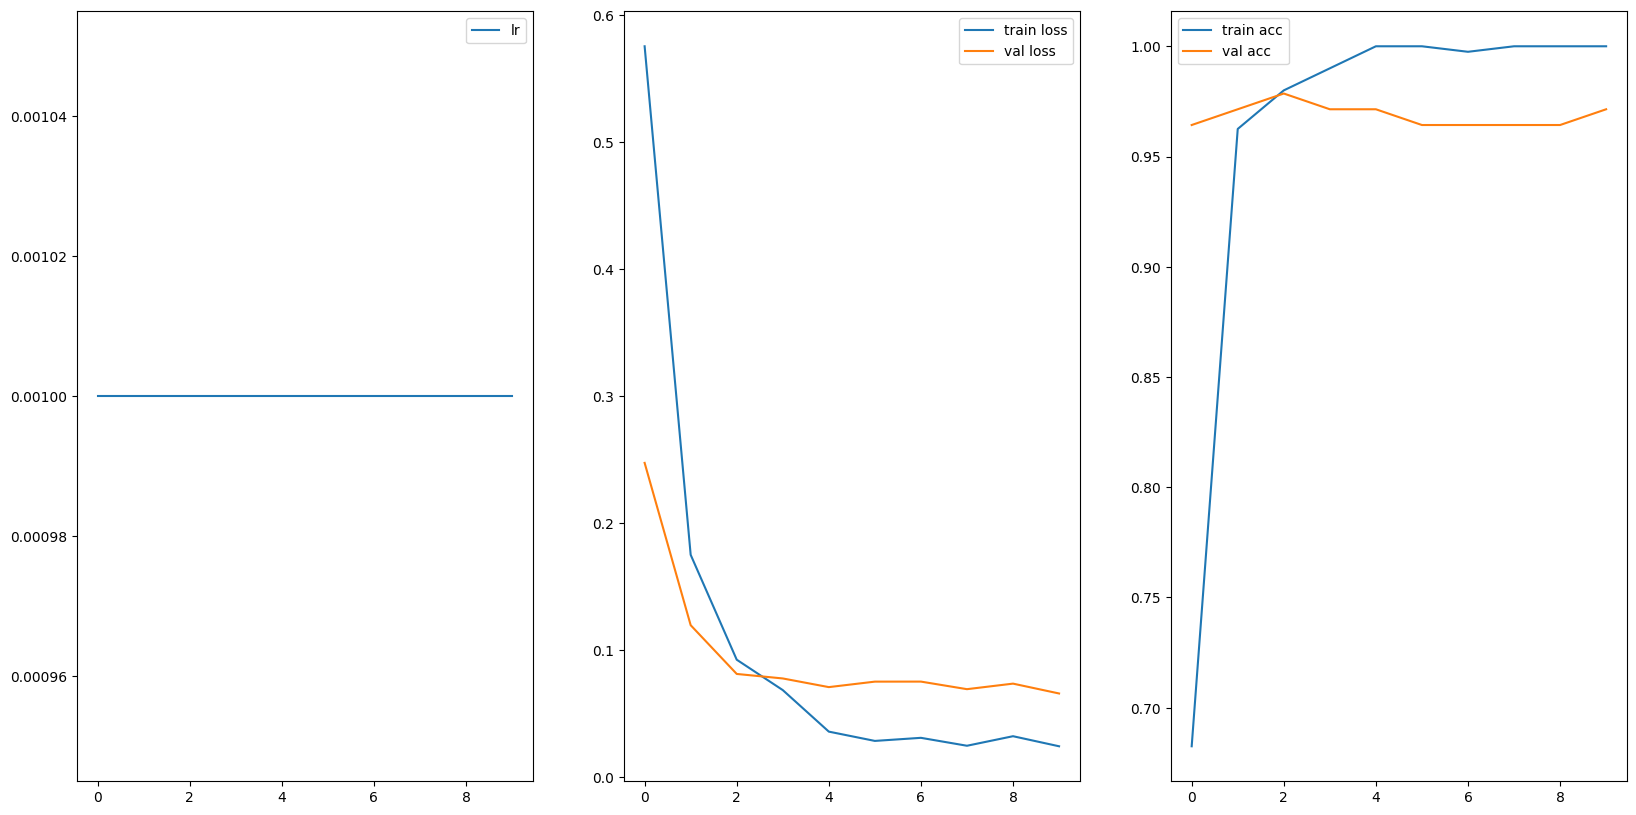

In [24]:
model = models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
scheduler = None

model_ft = train_model(model, dataloaders, criterion, optimizer, scheduler,
                       num_epochs=10)

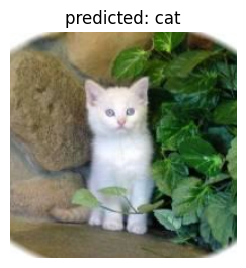

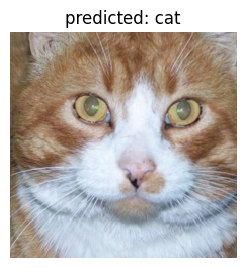

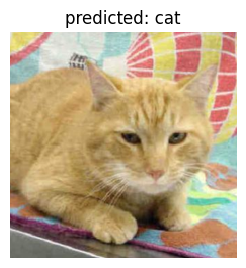

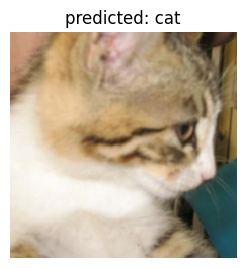

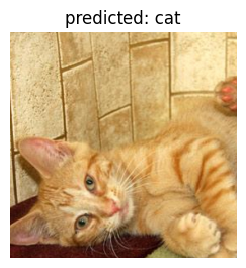

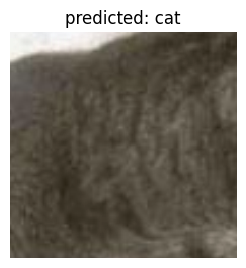

In [56]:
visualize_model(model_ft)

# Add augmentations

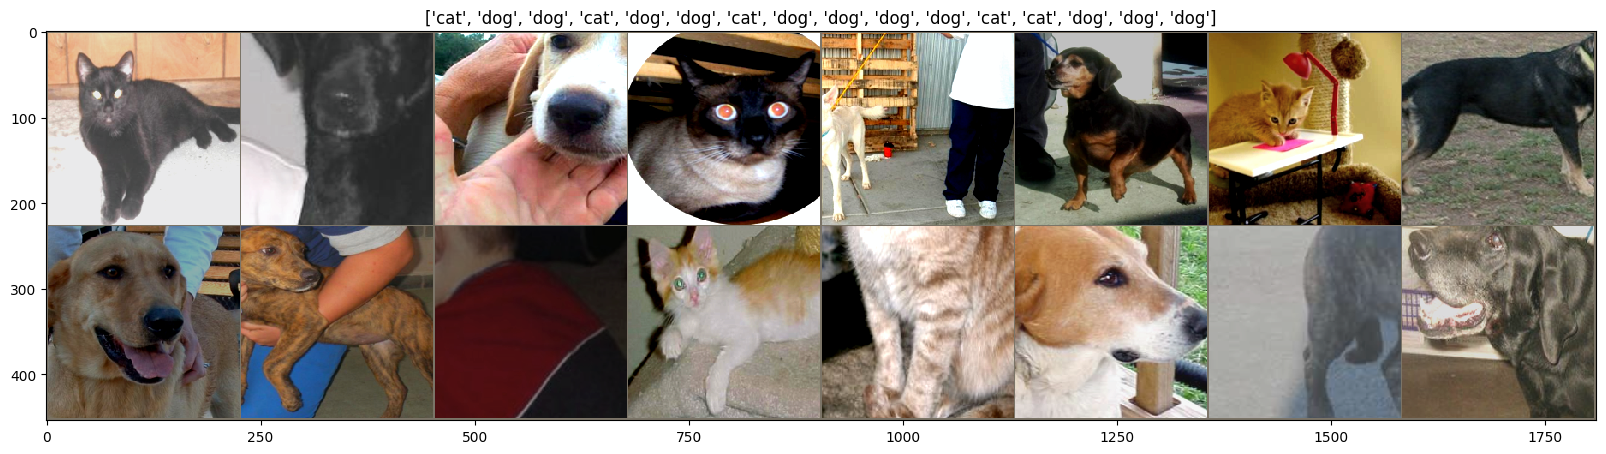

In [25]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.5, 0.5, 0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'cats_vs_dogs//'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Epoch 0/9
----------
train Loss: 0.4942 Acc: 0.7350
val Loss: 0.1319 Acc: 0.9857

Epoch 1/9
----------
train Loss: 0.2666 Acc: 0.8825
val Loss: 0.0845 Acc: 0.9857

Epoch 2/9
----------
train Loss: 0.2301 Acc: 0.9025
val Loss: 0.0666 Acc: 0.9857

Epoch 3/9
----------
train Loss: 0.1805 Acc: 0.9175
val Loss: 0.0548 Acc: 0.9929

Epoch 4/9
----------
train Loss: 0.2027 Acc: 0.8925
val Loss: 0.0731 Acc: 0.9786

Epoch 5/9
----------
train Loss: 0.1549 Acc: 0.9350
val Loss: 0.0821 Acc: 0.9714

Epoch 6/9
----------
train Loss: 0.1239 Acc: 0.9525
val Loss: 0.0513 Acc: 0.9857

Epoch 7/9
----------
train Loss: 0.1361 Acc: 0.9450
val Loss: 0.0426 Acc: 0.9857

Epoch 8/9
----------
train Loss: 0.1386 Acc: 0.9375
val Loss: 0.0444 Acc: 0.9857

Epoch 9/9
----------
train Loss: 0.1305 Acc: 0.9475
val Loss: 0.0434 Acc: 0.9786

Training complete in 0m 9s
Best val Acc: 0.992857


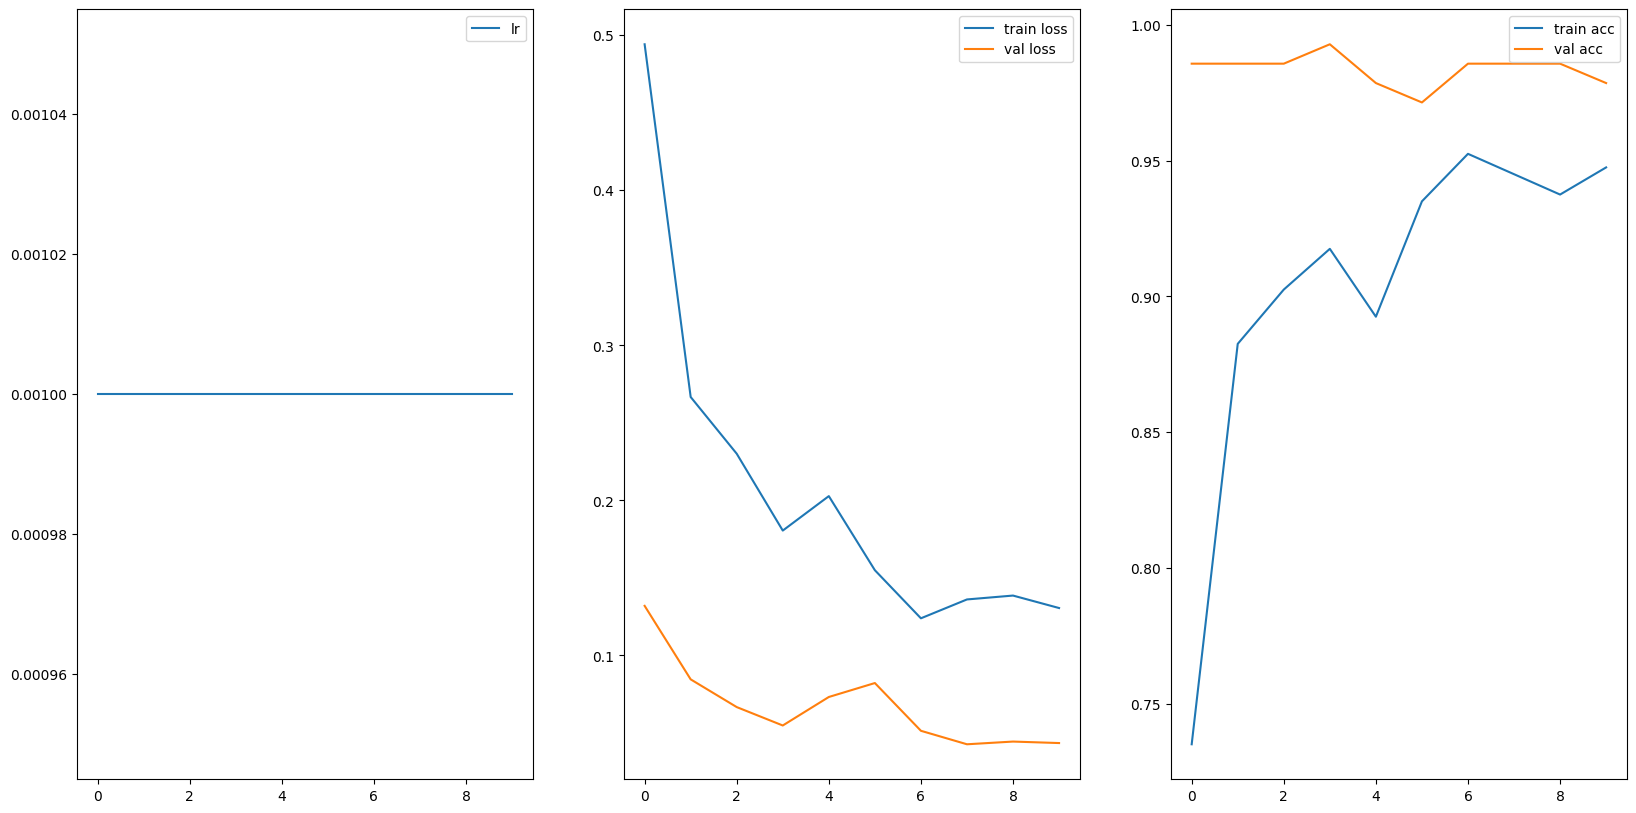

In [26]:
model2 = models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model2.fc = nn.Linear(num_ftrs, len(class_names))

model2 = model2.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model2.parameters(), lr=1e-3, momentum=0.9)
scheduler = None

model_ft2 = train_model(model2, dataloaders, criterion, optimizer, scheduler,
                       num_epochs=10)

# Add scheduling

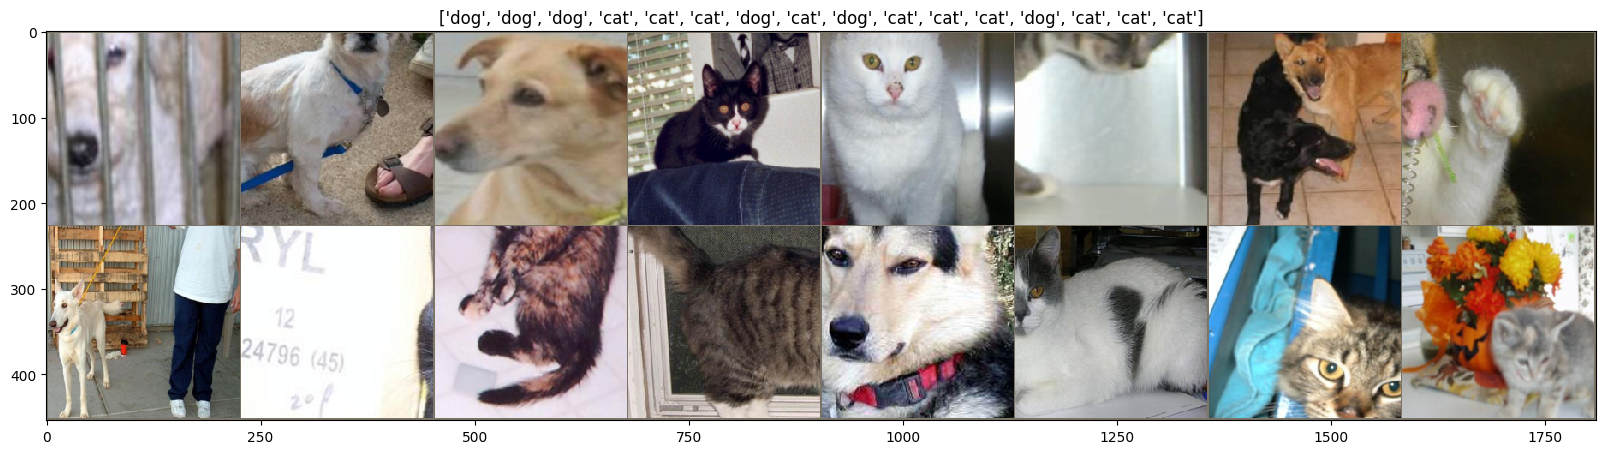

In [27]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.ColorJitter(0.5, 0.5, 0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'cats_vs_dogs/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Epoch 0/14
----------
train Loss: 0.4682 Acc: 0.7550
val Loss: 0.1247 Acc: 0.9643

Epoch 1/14
----------
train Loss: 0.2630 Acc: 0.8675
val Loss: 0.0875 Acc: 0.9714

Epoch 2/14
----------
train Loss: 0.2320 Acc: 0.8950
val Loss: 0.0702 Acc: 0.9714

Epoch 3/14
----------
train Loss: 0.1726 Acc: 0.9200
val Loss: 0.0550 Acc: 0.9857

Epoch 4/14
----------
train Loss: 0.1610 Acc: 0.9400
val Loss: 0.0464 Acc: 0.9857

Epoch 5/14
----------
train Loss: 0.1140 Acc: 0.9525
val Loss: 0.0478 Acc: 0.9857

Epoch 6/14
----------
train Loss: 0.1179 Acc: 0.9525
val Loss: 0.0505 Acc: 0.9857

Epoch 7/14
----------
train Loss: 0.1141 Acc: 0.9550
val Loss: 0.0526 Acc: 0.9857

Epoch 8/14
----------
train Loss: 0.1217 Acc: 0.9425
val Loss: 0.0508 Acc: 0.9857

Epoch 9/14
----------
train Loss: 0.1105 Acc: 0.9650
val Loss: 0.0535 Acc: 0.9857

Epoch 10/14
----------
train Loss: 0.1511 Acc: 0.9325
val Loss: 0.0472 Acc: 0.9857

Epoch 11/14
----------
train Loss: 0.1320 Acc: 0.9525
val Loss: 0.0496 Acc: 0.9857

Ep

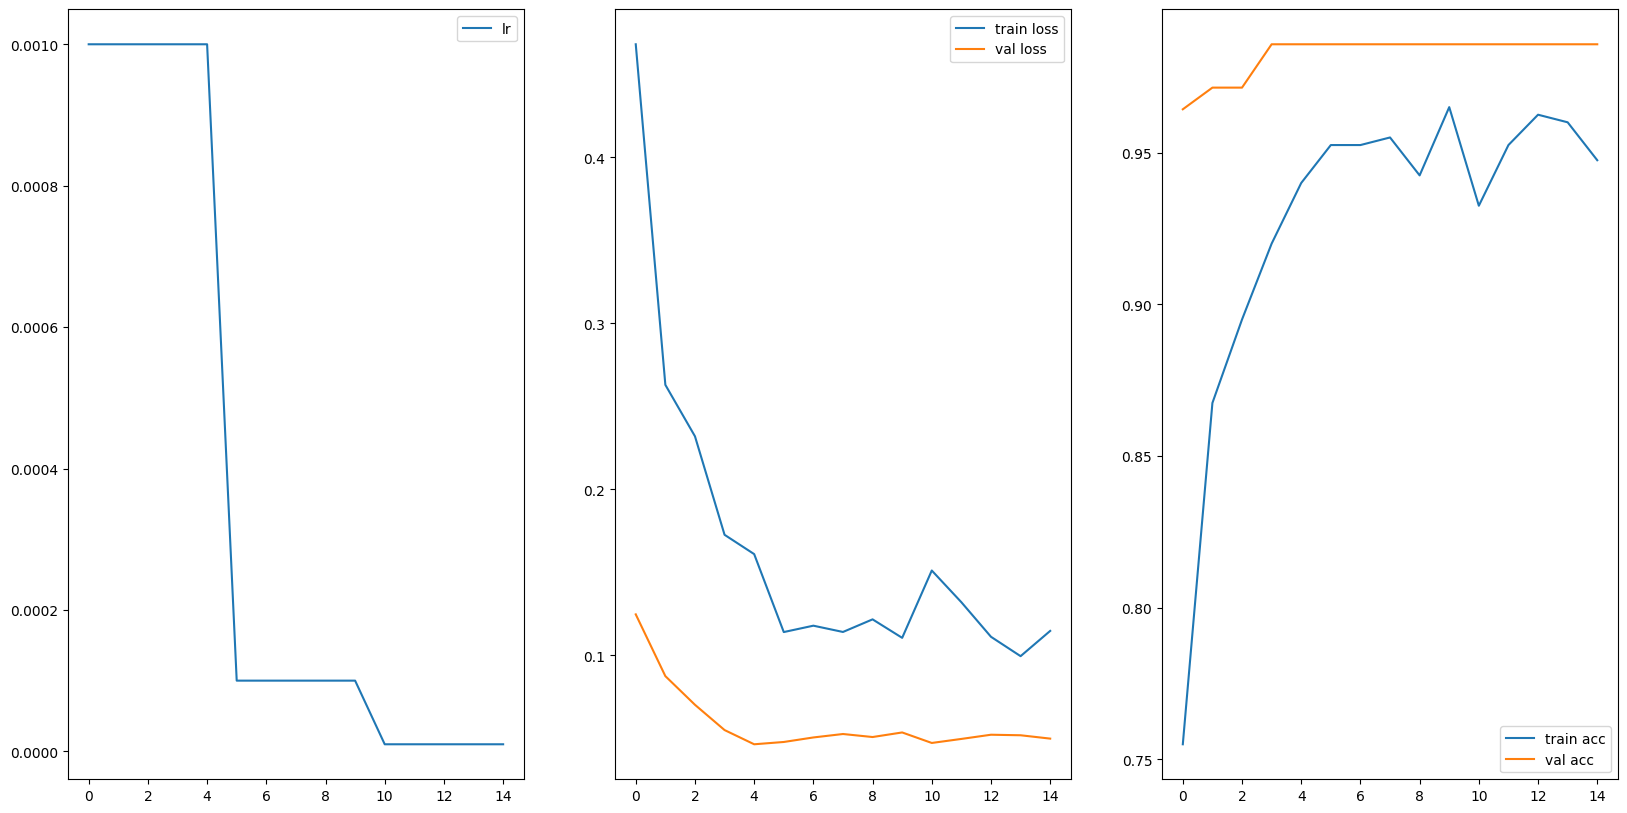

In [28]:
model3 = models.resnet18(pretrained=True)
num_ftrs = model3.fc.in_features
model3.fc = nn.Linear(num_ftrs, len(class_names))

model3 = model3.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model3.parameters(), lr=1e-3, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5)

model_ft3 = train_model(model3, dataloaders, criterion, optimizer, scheduler,
                       num_epochs=15)

# Bonus: LR test

Learning rate range test is a method for discovering the largest learning rate values that can be used to train a model without divergence. Data scientists are often interested in this information because large learning rates lead to faster model convergence than a small learning rates.

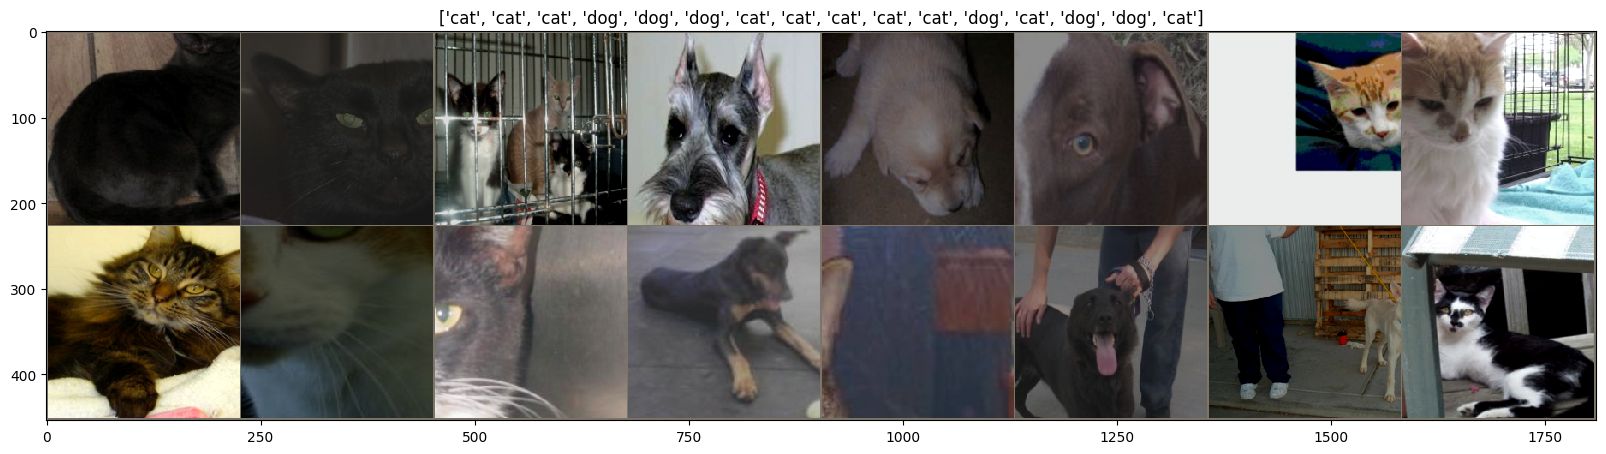

In [30]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.5, 0.5, 0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'cats_vs_dogs/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [31]:
N = len(dataloaders['train'])*10 # за 10 епох робимо 250 кроків

In [32]:
N

250

In [34]:
# 1e-6*gamma^250 = 1
# gamma^250 = 1e6
gamma = 1e6**(1/N)
gamma

1.0568175092136585

Epoch 0/9
----------
train Loss: 0.7502 Acc: 0.5325
val Loss: 0.6880 Acc: 0.6214

Epoch 1/9
----------
train Loss: 0.7171 Acc: 0.5625
val Loss: 0.6414 Acc: 0.6571

Epoch 2/9
----------
train Loss: 0.6950 Acc: 0.5850
val Loss: 0.5590 Acc: 0.7071

Epoch 3/9
----------
train Loss: 0.5623 Acc: 0.7225
val Loss: 0.3516 Acc: 0.9143

Epoch 4/9
----------
train Loss: 0.3902 Acc: 0.8350
val Loss: 0.1312 Acc: 0.9857

Epoch 5/9
----------
train Loss: 0.3460 Acc: 0.8600
val Loss: 0.0607 Acc: 0.9643

Epoch 6/9
----------
train Loss: 0.5419 Acc: 0.8075
val Loss: 0.7803 Acc: 0.7714

Epoch 7/9
----------
train Loss: 2.0390 Acc: 0.5725
val Loss: 36469.2333 Acc: 0.5000

Epoch 8/9
----------
train Loss: 4.4813 Acc: 0.5050
val Loss: 11844.5555 Acc: 0.5071

Epoch 9/9
----------
train Loss: 4.5587 Acc: 0.5225
val Loss: 51343.1556 Acc: 0.5000

Training complete in 0m 9s
Best val Acc: 0.985714


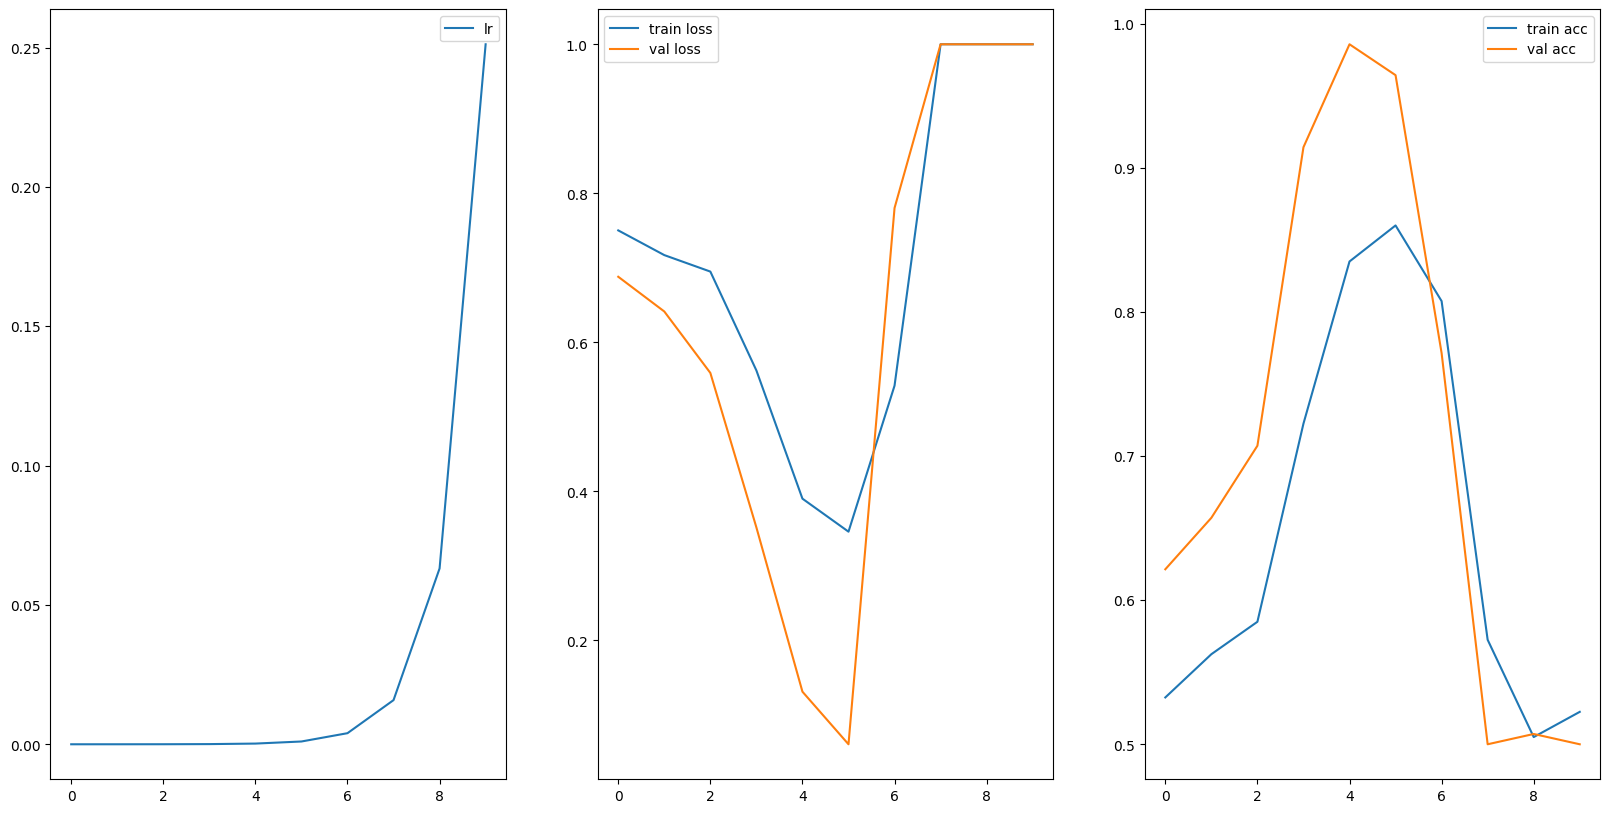

In [35]:
model4 = models.resnet18(pretrained=True)
num_ftrs = model4.fc.in_features
model4.fc = nn.Linear(num_ftrs, len(class_names))

model4 = model4.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model4.parameters(), lr=1e-6, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

model_ft4 = train_model(model4, dataloaders, criterion, optimizer, scheduler,
                       num_epochs=10, step_every_batch=True)

In [18]:
#вибрали ~~~4.5й крок

1e-6*gamma**(16*4.5)

5.345643593969717e-05

# Homework:  use pretrained model as feature extractor instead of finetuning and compare results

## Hint
You can read more about this in the documentation
`here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.